In [1]:
using DataFrames
using VegaLite, VegaDatasets
using JuMP
using LinearAlgebra
using GLPK
using ChainRulesCore
using CSV
using Plots

## Specify initial conditions

In [48]:
#initial wind speed
w_p_i=[0 0 0 0 0 1 0 0]
#initial cloud night
s_p_i=[0 1 0 0 0 0 0 0]

1×8 Matrix{Int64}:
 0  1  0  0  0  0  0  0

## Declaration of parameters

In [72]:
#Conventional generator Min and Max values
g_max = [20, 50, 100]
g_min = [5,20, 0]

#Conventional generator per MW cost
c_g = [27.7, 35.5, 10000]

#Conventional generator no load cost
c_g0 = [120, 100, 10000]

#Wind generator per MW cost
c_w = 10

#Solar generator per MW cost
c_s = 10

# Wind power maximum value at each hour for 24 hours
w_f = [20 40]

#Solar power maximum value at each hour for 24 hours
s_f = [15 30]

# Load demand for one day or 24 hours
d = [35.89 45.5 41.9 38.6 43.16 65.56 45.02 35.63 40.31 56.85 74.55 90 57.22 49.6 59.49 83.5 76.07 90.33 33.78 39.41 34.96 36.73 32.5 29.65]


#Minimum uptime and downtime for conventional generation
UTg=[2,4,0]
UDg=[2,4,0]
#UTg=[1,1,0]
#UDg=[1,1,0]

#Minimum up and down ramp rate for conventional generator
UR=[10,25,50]
DR=[10,25,50]
#UR=[2,5,100]
#DR=[2,5,100]

3-element Vector{Int64}:
 10
 25
 50

## Unit Commitment MILP Model

In [28]:
function solve_ed(g_max, g_min, c_g, c_w, d, w_f, s_f)
    ed = Model(GLPK.Optimizer)
    
#Wind and Solar generation variable for each hour    
    @variable(ed, 0 <= w[i=1:1,j=1:24] <= w_f[1])
    @variable(ed, 0 <= s[i=1:1,j=1:24] <= s_f[1])
    @variable(ed, w_diff[i=1:1,j=1:24])
    @constraint(ed,[i=1:1,j=1:24], w_diff[i,j] == w_f[1] .- w[i,j])   
    @variable(ed, s_diff[i=1:1,j=1:24])
    @constraint(ed,[i=1:1,j=1:24], s_diff[i,j] == s_f[1] .- s[i,j]) 
    
#Unit commitment binary variable for conventional generator    
    @variable(ed,u[i=1:3,j=1:24], Bin)
    
#Conventional generation varaible for each hour     
    @variable(ed, 0 <= g[i=1:3,j=1:24] <= g_max[i])
    
#Objective Minimize generation production cost    
    @objective(ed, Min, sum(sum(((g[i,j] *c_g[i])+(u[i,j]*c_g0[i])) for i=1:3)+ (c_w* w[1,j])+(c_s*s[1,j]) for j=1:24))
    @variable(ed,cost[j=1:24])
    @constraint(ed,[j=1:24], cost[j] == sum(((g[i,j] *c_g[i])+(u[i,j]*c_g0[i])) for i=1:3)+ (c_w* w[1,j])+(c_s*s[1,j]))
    
#Conventional generation constraints    
    @constraint(ed,[i=1:3,j=1:24], g[i,j] <= g_max[i]*u[i,j])
    @constraint(ed,[i=1:3,j=1:24], g[i,j] >= g_min[i]*u[i,j]) 
    @constraint(ed,[i=1:1,j=12:20],s[i,j] ==0) 
    
#Power balance equation constraint   
    @constraint(ed,[j=1:24],(sum(g[i,j] for i=1:3)+ w[1,j]+ s[1,j] == d[1,j]))

#Minimum uptime and downtime constraint   
    @constraint(ed,[j=2:24,i=1:3,s=j+1:min(24,j.+UTg[i,1]-1)],u[i,s]>=u[i,j]-u[i,j-1])
    @constraint(ed,[j=1:1,i=1:3,s=j+1:min(24,j.+UTg[i,1]-1)],u[i,s]>=u[i,j]-0)
    @constraint(ed,[j=2:24,i=1:3,s=j+1:min(24,j.+UDg[i,1]-1)],(1-u[i,s])>=u[i,j-1]-u[i,j])
    @constraint(ed,[j=1:1,i=1:3,s=j+1:min(24,j.+UDg[i,1]-1)],(1-u[i,s])>=0-u[i,j])

#Ramp rate up and down constraint
    @constraint(ed,[i=1:3,j=2:24], g[i,j]-g[i,j-1]<=UR[i])
    @constraint(ed,[i=1:3,j=1:1], g[i,j]-0<=UR[i])
    @constraint(ed,[i=1:3,j=2:24], g[i,j-1]-g[i,j]<=DR[i])
    @constraint(ed,[i=1:3,j=1:1], 0-g[i,j]<=DR[i])
    
    optimize!(ed)
    return JuMP.value.(g), JuMP.value.(w),JuMP.value.(s), objective_value(ed),JuMP.value.(u),JuMP.value.(w_diff),JuMP.value.(s_diff),JuMP.value.(cost)
end

solve_ed (generic function with 1 method)

In [29]:
(g_opt, w_opt, s_opt, obj,u,w_diff,s_diff,cost) = solve_ed(g_max, g_min, c_g, c_w, d, w_f, s_f);

println("Dispatch of Conventional Generators: ",g_opt, " MW")
println("\n")
println("Dispatch of Wind Generator: ",w_opt, " MW")
println("\n")
println("Dispatch of Solar Generator: ",s_opt, " MW")
println("\n")
println("Binary:",u, " Bin")
println("\n")
println("Total cost: ", obj, "\$")

Dispatch of Conventional Generators: [5.0 10.5 6.899999999999999 5.0 8.159999999999997 0.0 0.0 0.0 0.0 0.0 19.549999999999997 20.0 17.220000000000006 9.600000000000012 19.490000000000002 20.0 20.0 20.0 13.780000000000001 19.409999999999997 5.0 5.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 30.560000000000002 20.0 20.0 20.0 21.85 20.0 50.0 19.999999999999993 19.99999999999999 20.0 43.5 36.06999999999999 49.999999999999986 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.3300000000000125 0.0 0.0 0.0 0.0 0.0 0.0] MW


Dispatch of Wind Generator: [15.89 20.0 20.0 20.0 20.0 20.0 20.0 15.630000000000003 20.0 20.0 20.0 20.0 20.0 20.0 20.0 20.0 20.0 20.0 20.0 20.0 20.0 20.0 20.0 20.0] MW


Dispatch of Solar Generator: [15.0 15.0 15.0 13.600000000000001 15.0 15.0 5.020000000000003 0.0 0.3100000000000023 15.0 15.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 9.96 11.729999999999997 12.5 9.649999999999999] MW


Binary:[1.0 1.0 1.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 1.0 1.0

In [30]:
g_opt_tot=g_opt[1,:].+g_opt[2,:]+g_opt[3,:]
g_opt

3×24 Matrix{Float64}:
 5.0  10.5  6.9  5.0  8.16   0.0    0.0  …  13.78  19.41  5.0  5.0  0.0  0.0
 0.0   0.0  0.0  0.0  0.0   30.56  20.0      0.0    0.0   0.0  0.0  0.0  0.0
 0.0   0.0  0.0  0.0  0.0    0.0    0.0      0.0    0.0   0.0  0.0  0.0  0.0

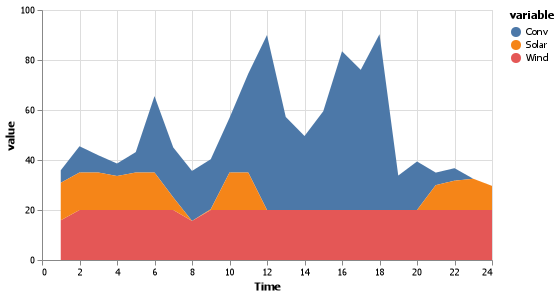

In [31]:
g_opt_tot=g_opt[1,:].+g_opt[2,:]+g_opt[3,:]
sNames = ["Conv","Wind","Solar"]
xLabels = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]

df = DataFrame(Time=xLabels, Conv=vec(g_opt_tot), Wind=vec(w_opt), Solar=vec(s_opt))
df |> stack |> @vlplot(:area, x=:Time, y={:value, stack=:zero}, color="variable:n",width=450, height=250)

In [32]:
s_diff[1:1,12:20] .=0;
p=heatmap([xLabels],["Wind","Solar"],[w_diff;s_diff],c=cgrad(:amp),size = (450,200),xlabel="Time")
p
savefig(p,"og-wastage.svg")

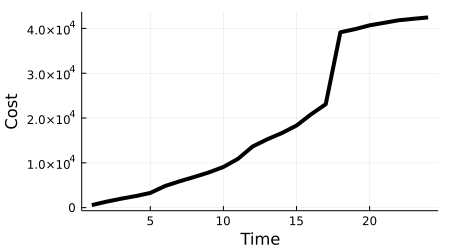

In [33]:
plot([xLabels],cumsum(vec(cost)),linewidth = 4, linecolor = :black,size = (450,250),xlabel="Time",ylabel="Cost", legend = false) #|> save("og-cost.svg")

## Stochastic Unit Commitment with DTMC for wind speed and cloud cover

In [49]:
#Stochastic Model

# Wind power maximum value at each hour for 24 hours
w_pt_df = CSV.File("./wind_transitionMat.csv", header=0, delim=',') |> DataFrame 
w_pt=Matrix(w_pt_df)

#Solar power maximum value at each hour for 24 hours
s_pt_df = CSV.File("./solar_transitionMat.csv", header=0, delim=',') |> DataFrame
s_pt=Matrix(s_pt_df)

#stochastic problem

function wind_pow_corr(p_t)
    w_pow=[0 0.06 0.18 0.56 0.85 1 0.96 0.87];
    return w_f[2]*sum(w_pow.*p_t);
end

function solar_pow_corr(p_t)
    s_pow=[1 1 0.94 0.85 0.7 0.5 0.3 0.1];
    return s_f[2]*sum(s_pow.*p_t);
end

function solve_st(g_max, g_min, c_g, c_w, d, w_f, s_f,w_p_i,s_p_i)
    st = Model(GLPK.Optimizer)
    
#Wind and Solar generation variable for each hour    
    @variable(st, 0 <= w[i=1:1,j=1:24] <= wind_pow_corr(w_p_i*w_pt^j))
    @variable(st, 0 <= s[i=1:1,j=1:24] <= solar_pow_corr(s_p_i*s_pt^j))   
    @constraint(st,[i=1:1,j=12:20],s[i,j] ==0) 
    @variable(st, w_diff[i=1:1,j=1:24])
    @constraint(st,[i=1:1,j=1:24], w_diff[i,j] == wind_pow_corr(w_p_i*w_pt^j) - w[i,j])   
    @variable(st, s_diff[i=1:1,j=1:24])
    @constraint(st,[i=1:1,j=1:24], s_diff[i,j] == solar_pow_corr(s_p_i*s_pt^j) - s[i,j])   

#Unit commitment binary variable for conventional generator    
    @variable(st,u[i=1:3,j=1:24], Bin)
    
#Conventional generation varaible for each hour     
    @variable(st, 0 <= g[i=1:3,j=1:24] <= g_max[i])
    
#Objective Minimize generation production cost    
    @objective(st, Min, sum(sum(((g[i,j] *c_g[i])+(u[i,j]*c_g0[i])) for i=1:3)+ (c_w* w[1,j])+(c_s*s[1,j]) for j=1:24))
    @variable(st,cost[j=1:24])
    @constraint(st,[j=1:24], cost[j] == sum(((g[i,j] *c_g[i])+(u[i,j]*c_g0[i])) for i=1:3)+ (c_w* w[1,j])+(c_s*s[1,j]))
    
#Conventional generation constraints    
    @constraint(st,[i=1:3,j=1:24], g[i,j] <= g_max[i]*u[i,j])
    @constraint(st,[i=1:3,j=1:24], g[i,j] >= g_min[i]*u[i,j]) 
    
    
#Power balance equation constraint   
    @constraint(st,[j=1:24],(sum(g[i,j] for i=1:3)+ w[1,j]+ s[1,j] == d[1,j]))

#Minimum uptime and downtime constraint   
    @constraint(st,[j=2:24,i=1:3,s=j+1:min(24,j.+UTg[i,1]-1)],u[i,s]>=u[i,j]-u[i,j-1])
    @constraint(st,[j=1:1,i=1:3,s=j+1:min(24,j.+UTg[i,1]-1)],u[i,s]>=u[i,j]-0)
    @constraint(st,[j=2:24,i=1:3,s=j+1:min(24,j.+UDg[i,1]-1)],(1-u[i,s])>=u[i,j-1]-u[i,j])
    @constraint(st,[j=1:1,i=1:3,s=j+1:min(24,j.+UDg[i,1]-1)],(1-u[i,s])>=0-u[i,j])

#Ramp rate up and down constraint
    @constraint(st,[i=1:3,j=2:24], g[i,j]-g[i,j-1]<=UR[i])
    @constraint(st,[i=1:3,j=1:1], g[i,j]-0<=UR[i])
    @constraint(st,[i=1:3,j=2:24], g[i,j-1]-g[i,j]<=DR[i])
    @constraint(st,[i=1:3,j=1:1], 0-g[i,j]<=DR[i])
    
    optimize!(st)
    return JuMP.value.(g), JuMP.value.(w),JuMP.value.(s), objective_value(st),JuMP.value.(u),JuMP.value.(w_diff),JuMP.value.(s_diff),JuMP.value.(cost)
end

solve_st (generic function with 1 method)

In [73]:
(g_opt, w_opt, s_opt, obj,u, w_diff, s_diff,cost) = solve_st(g_max, g_min, c_g, c_w, d, w_f, s_f,w_p_i,s_p_i);
println("Dispatch of Coventional Generators: ",g_opt, " MW")
println("\n")
println("Dispatch of Wind Generator: ",w_opt, " MW")
println("\n")
println("Dispatch of Solar Generator: ",s_opt, " MW")
println("\n")
println("Wind Power Wastage: ",w_diff, " MW")
println("\n")
println("Solar Power Wastage: ",s_diff, " MW")
println("\n")
println("Up/Down of generators:",u, " Bin")
println("\n")
println("Total cost: ", obj, "\$")


Dispatch of Coventional Generators: [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 8.355131917534083 10.0 0.0 0.0 8.455628414738463 18.455628414738463 20.0 15.0 5.0 8.077002274559312 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 20.47456936138392 20.0 20.0 20.0 20.0 24.185520189263244 49.185520189263244 26.331052390378233 20.0 20.0 33.94187615417102 24.903391758400964 44.10357552102343 20.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0] MW


Dispatch of Wind Generator: [35.89 33.7843964828 32.25505739222036 31.402381154972012 30.94489025116989 30.715790211514232 25.020000000000003 15.629999999999999 20.310000000000002 30.676871958234912 30.74227704317396 30.814479810736756 30.888947609621766 29.6 31.03437158526154 31.102495431090517 31.16660824159903 31.226424478976572 8.780000000000001 31.332997725440684 31.379966720405772 31.422980511874545 31.462277273681437 29.65] MW


Dispatch of Solar Generator: [0.0 11.715603517200002 9.644

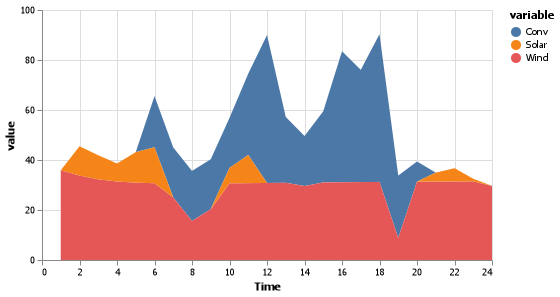

In [74]:
g_opt_tot=g_opt[1,:].+g_opt[2,:]+g_opt[3,:]
sNames = ["Conv","Wind","Solar"]
xLabels = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]

df = DataFrame(Time=xLabels, Conv=vec(g_opt_tot), Wind=vec(w_opt), Solar=vec(s_opt))
df |> stack |> @vlplot(:area, x=:Time, y={:value, stack=:zero}, color="variable:n",width=450, height=250)

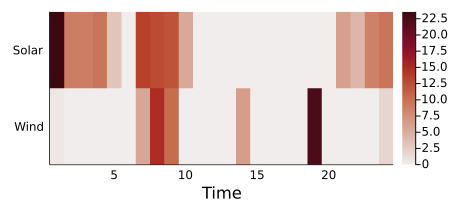

In [67]:
s_diff[1:1,12:20] .=0;
p=heatmap([xLabels],["Wind","Solar"],[w_diff;s_diff],c=cgrad(:amp),size = (450,200),xlabel="Time")
p
#savefig(p,"st-wastage.svg")

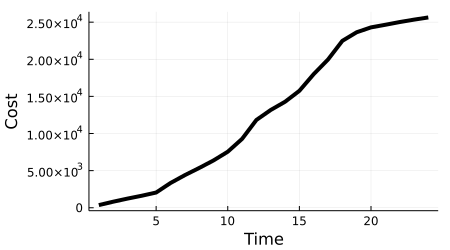

In [52]:
plot([xLabels],cumsum(vec(cost)),linewidth = 4, linecolor = :black,size = (450,250),xlabel="Time",ylabel="Cost", legend = false) #|> save("st-cost.svg")